# Noise (& beam) response

## Download

You can download the data directory `data_tutorials` using:

```bash
wget https://www.mso.anu.edu.au/~amarchal/shared/ivis/data_tutorials.zip
unzip data_tutorials.zip -d data_tutorials
rm data_tutorials.zip
```

Kindly provided by Enrico Di Teodoro (UniFI) and Karlie Noon (RSAA/ANU).

## Method
<div style="text-align: justify;">
    
> To characterize the **image-domain response of the noise** in the visibility data, we performed imaging on a single realization constructed using the <code>SIGMA</code> array available in the Measurement Set.  
We then computed the one-dimensional spatial **power spectrum** <em>P(k)</em> of the resulting image.
>
> Note that to fully characterize <em>P(k)</em>, we recommend repeating this procedure over **multiple random realizations** (typically at least 20) and averaging the resulting spectra.

</div>

### Read data

In [1]:
import glob
from tqdm import tqdm as tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from astropy.io import fits
from radio_beam import Beam
from astropy import units as u
from reproject import reproject_interp

from ivis.io import DataProcessor
from ivis.imager import Imager
from ivis.logger import logger
from ivis.utils import dutils, fourier

from ivis.models import ClassicIViS

path_ms = "./data_tutorials/ivis_data/msl_mw/" #directory of measurement sets    
path_beams = "./data_tutorials/ivis_data/BEAMS/" #directory of primary beams
path_sd = None #path single-dish data
pathout = "./data_tutorials/ivis_data/" #path where data will be packaged and stored

#REF WCS INPUT USER
filename = "./data_tutorials/ivis_data/MW-C10_mom0th_NHI.fits"
target_header = fits.open(filename)[0].header
shape = (target_header["NAXIS2"],target_header["NAXIS1"])
    
#create data processor
data_processor = DataProcessor(path_ms, path_beams, path_sd, pathout)

# pre-compute pb and interpolation grids — this can be commented after first compute
logger.disabled = True
data_processor.compute_pb_and_grid(target_header, fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits") 
logger.disabled = False

pb, grid = data_processor.read_pb_and_grid(fitsname_pb="reproj_pb.fits", fitsname_grid="grid_interp.fits")

#Dummy sd array
sd = np.zeros(shape)
#Dummy Beam sd
beam_sd = Beam(1*u.deg, 1*u.deg, 1.e-12*u.deg)

[2025-08-22 23:43:17 UTC] [IViS] [info] [Initialize DataProcessor ]
100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


In [2]:
#Read data
vis_data = data_processor.read_vis_from_scratch(uvmin=0, uvmax=np.inf,
                                                target_frequency=None,
                                                target_channel=0,
                                                extension=".ms",
                                                blocks='single',
                                                max_workers=1)

[2025-08-22 23:43:20 UTC] [IViS] [info] Processing single scheduling block.
[2025-08-22 23:43:20 UTC] [IViS] [info] Number of MS files = 5
[2025-08-22 23:43:20 UTC] [IViS] [info] Reading MS files with single thread.
[2025-08-22 23:43:20 UTC] [IViS] [info] Processing file 1/5: ./data_tutorials/ivis_data/msl_mw/MW-C10_1_MW_chan_-32kms.ms
[2025-08-22 23:43:20 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050093 Hz | Velocity (LSRK): -32.0000000000517 km/s
[2025-08-22 23:43:20 UTC] [IViS] [info] Extracted 626313 valid baselines.
[2025-08-22 23:43:20 UTC] [IViS] [info] Time for iteration 1: 0.29s, ETA: 0.02 minutes
[2025-08-22 23:43:20 UTC] [IViS] [info] Processing file 2/5: ./data_tutorials/ivis_data/msl_mw/MW-C10_2_MW_chan_-32kms.ms
[2025-08-22 23:43:20 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050096 Hz | Velocity (LSRK): -32.00000000010202 km/s
[2025-08-22 23:43:21 UTC] [IViS] [info] Extracted 1068720 valid baselines.
[2025-08-22 23:43:21 UTC] [IV

### Empty sky model

In [3]:
sky_model = np.zeros(shape, dtype=np.float32)

### Set PB=1 (depends on the response you want: (A*N) or N

In [4]:
#pb = np.full(pb.shape,1)

### Simulated visibilities (using IViS forward model)

In [5]:
#Model visibilities with IVis forward single frequency model
image_processor = Imager(vis_data,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         None,            # single dish data in unit of Jy/arcsec^2
                         None,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         sky_model,   # init array of parameters
                         0,       # maximum number of iterations
                         0,     # hyper-parameter single-dish
                         False,    # impose a positivity constaint
                         0,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)

model = ClassicIViS()
model_vis =  image_processor.forward_model(model=model)

[2025-08-22 23:43:25 UTC] [IViS] [info] [Initialize Imager        ]
[2025-08-22 23:43:25 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 0
[2025-08-22 23:43:25 UTC] [IViS] [warning] lambda_sd = 0 - No short spacing correction (ignoring single dish data).
[2025-08-22 23:43:25 UTC] [IViS] [warning] CUDA not available. Falling back on CPU.
[2025-08-22 23:43:25 UTC] [IViS] [info] Nw <= 1 or None, using flat-sky NUFFT (no w-stacking).


### Adding realistic noise from the MeerKAT data beam

In [125]:
#Add noise
fact=1 #Scale the noise with this if needed
noise_real = np.random.normal(loc=0.0, scale=vis_data.sigma*fact)
noise_imag = np.random.normal(loc=0.0, scale=vis_data.sigma*fact)
noise = noise_real + 1j * noise_imag

# Add realistic thermal noise to the model visibilities
vis_data.data = model_vis + noise

### Imaging using IViS

In [126]:
#user parameters
max_its = 20
lambda_sd = 0 #not relevant here
lambda_r = 1 #Control the strength of the Laplacian filtering
device = 0#"cpu" #0 is GPU and "cpu" is CPU
positivity = False #Set to False because noise fluctuates around 0

#Initial parameters (zero array)
init_params = np.zeros(shape, dtype=np.float32)

#create image processor
image_processor = Imager(vis_data,      # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         sd,            # single dish data in unit of Jy/arcsec^2
                         beam_sd,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         init_params,   # init array of parameters
                         max_its,       # maximum number of iterations
                         lambda_sd,     # hyper-parameter single-dish
                         positivity,    # impose a positivity constaint
                         device,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)
#get image
model = ClassicIViS(lambda_r=lambda_r)
noise = image_processor.process(model=model, units="Jy/arcsec^2") #"Jy/arcsec^2" or "K"

[2025-08-23 00:38:19 UTC] [IViS] [info] [Initialize Imager        ]
[2025-08-23 00:38:19 UTC] [IViS] [info] Number of iterations to be performed by the optimizer: 20
[2025-08-23 00:38:19 UTC] [IViS] [warning] lambda_sd = 0 - No short spacing correction (ignoring single dish data).
[2025-08-23 00:38:19 UTC] [IViS] [warning] CUDA not available. Falling back on CPU.
[2025-08-23 00:38:19 UTC] [IViS] [info] Nw <= 1 or None, using flat-sky NUFFT (no w-stacking).
[2025-08-23 00:38:19 UTC] [IViS] [info] Starting optimisation (using LBFGS-B)
[2025-08-23 00:38:19 UTC] [IViS] [info] Optimizer not bounded - Positivity == False
[2025-08-23 00:38:26 UTC] [IViS] [info] [PID 41469] Total cost: 5.07107e+06
[2025-08-23 00:38:30 UTC] [IViS] [info] [PID 41469] Total cost: 5.77375e+09
[2025-08-23 00:38:32 UTC] [IViS] [info] [PID 41469] Total cost: 5.04374e+06
[2025-08-23 00:38:33 UTC] [IViS] [info] [PID 41469] Total cost: 5.02557e+06
[2025-08-23 00:38:35 UTC] [IViS] [info] [PID 41469] Total cost: 5.01381e+

In [127]:
#mean pb
filenames = sorted(glob.glob(path_beams+"*.fits"))
n_beams = len(filenames)
pb_all = np.zeros((n_beams,noise.shape[0],noise.shape[1]))
w = dutils.wcs2D(target_header)
for i in tqdm(np.arange(n_beams)):
    #open beam cube
    hdu_pb = fits.open(filenames[i])
    hdr_pb = hdu_pb[0].header
    pb2 = hdu_pb[0].data
    pb2[pb2 != pb2] = 0.
    w_pb = dutils.wcs2D(hdr_pb)
    pb2, footprint = reproject_interp((pb2,w_pb.to_header()), w.to_header(), shape)
    pb2[pb2 != pb2] = 0.
    pb_all += pb2
    pb_mean = np.nanmean(pb_all,0)
    pb_mean /= np.nanmax(pb_mean)    
    mask = np.where(pb_mean > 0.2, 1, np.nan)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


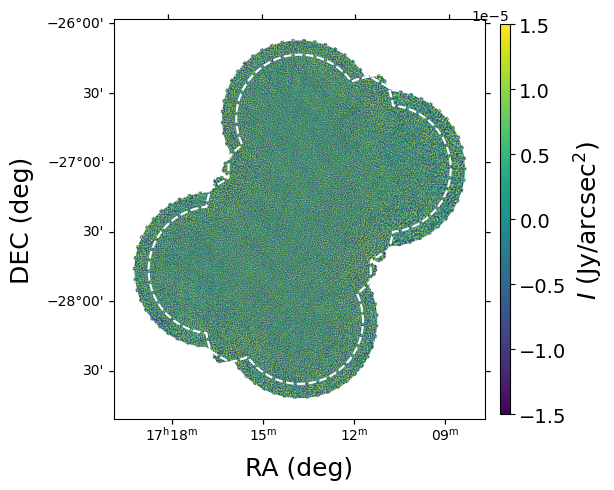

In [128]:
#PLOT RESULT
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"RA (deg)", fontsize=18.)
ax.set_ylabel(r"DEC (deg)", fontsize=18.)
img = ax.imshow(noise*mask, vmin=-1.5e-5, vmax=1.5e-5, origin="lower")
ax.contour(pb_mean, linestyles="--", levels=[0.2, 0.3], colors=["w","w"])
colorbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.78])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$I$ (Jy/arcsec$^{2})$", fontsize=18.)
#    plt.savefig(pathout + 'ivis_result_cloud_MeerKAT.png', format='png', bbox_inches='tight', pad_inches=0.02, dpi=400)

## Compute the P(k)

In [129]:
# Get tapper for apodization
tapper = fourier.apodize(0.97, shape)
# Reove the mean
field_zm = noise - np.mean(noise)
# Apply apodization function
field_zm_apod = field_zm * tapper

# Compute the 1D P(k)
ks, sps1d_n = fourier.powspec(field_zm_apod, reso=(target_header["CDELT2"]*u.deg).to(u.arcmin).value)

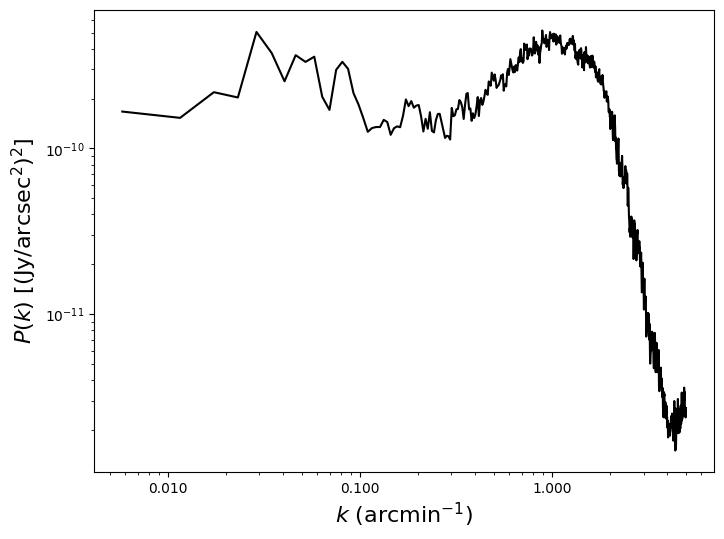

In [130]:
#Plot sps1D                                                                                                                                                                                                                                            
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')                                                                                                                                                                                                                                                                            
ax.plot(ks, sps1d_n, "-k")                                                                                                             
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$k$ (arcmin$^{-1}$)", fontsize = 16)
ax.set_ylabel(r"$P(k)$ [(Jy/arcsec$^2$)$^2$]", fontsize = 16)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#plt.savefig('plot/SPS_.png', format='png', bbox_inches='tight', pad_inches=0.02)

## Important note

<div style="text-align: justify;">

> It is useful to note that the effective beam response is inherently built into the imaging process. In this case, the sky model contains noise rather than a single point source, but the resulting beam still reflects the non-linear nature of the inversion.
>
> When modeling the power spectrum P(k), the effective beam—shaped by the regularization—acts *after* the noise, not before. This distinction is important when interpreting the noise properties of the reconstructed image.
>
> This is fundamentally different from a CLEAN approach, where the model is convolved with a chosen restoring beam, and the noise is added back afterward by gridding the residual visibilities.

</div>

## Compare with P(k) of signal

In [86]:
#Read data
vis_data_s = data_processor.read_vis_from_scratch(uvmin=0, uvmax=np.inf,
                                                 target_frequency=None,
                                                 target_channel=0,
                                                 extension=".ms",
                                                 blocks='single',
                                                 max_workers=1)

# create image processor
image_processor = Imager(vis_data_s,    # visibilities
                         pb,            # array of primary beams
                         grid,          # array of interpolation grids
                         sd,            # single dish data in unit of Jy/arcsec^2
                         beam_sd,       # beam of single-dish data in radio_beam format
                         target_header, # header on which to image the data
                         init_params,   # init array of parameters
                         max_its,       # maximum number of iterations
                         lambda_sd,     # hyper-parameter single-dish
                         positivity,    # impose a positivity constaint
                         device,        # device: 0 is GPU; "cpu" is CPU
                         beam_workers=1)
# choose model
model = ClassicIViS(lambda_r=1)
# get image
result = image_processor.process(model=model, units="Jy/arcsec^2") #"Jy/arcsec^2" or "K"

[2025-08-23 00:14:23 UTC] [IViS] [info] Processing single scheduling block.
[2025-08-23 00:14:23 UTC] [IViS] [info] Number of MS files = 5
[2025-08-23 00:14:23 UTC] [IViS] [info] Reading MS files with single thread.
[2025-08-23 00:14:23 UTC] [IViS] [info] Processing file 1/5: ./data_tutorials/ivis_data/msl_mw/MW-C10_1_MW_chan_-32kms.ms
[2025-08-23 00:14:23 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050093 Hz | Velocity (LSRK): -32.0000000000517 km/s
[2025-08-23 00:14:23 UTC] [IViS] [info] Extracted 626313 valid baselines.
[2025-08-23 00:14:23 UTC] [IViS] [info] Time for iteration 1: 0.08s, ETA: 0.01 minutes
[2025-08-23 00:14:23 UTC] [IViS] [info] Processing file 2/5: ./data_tutorials/ivis_data/msl_mw/MW-C10_2_MW_chan_-32kms.ms
[2025-08-23 00:14:23 UTC] [IViS] [info] Selected channel: 0 | Frequency: 1420557366.6050096 Hz | Velocity (LSRK): -32.00000000010202 km/s
[2025-08-23 00:14:23 UTC] [IViS] [info] Extracted 1068720 valid baselines.
[2025-08-23 00:14:23 UTC] [IV

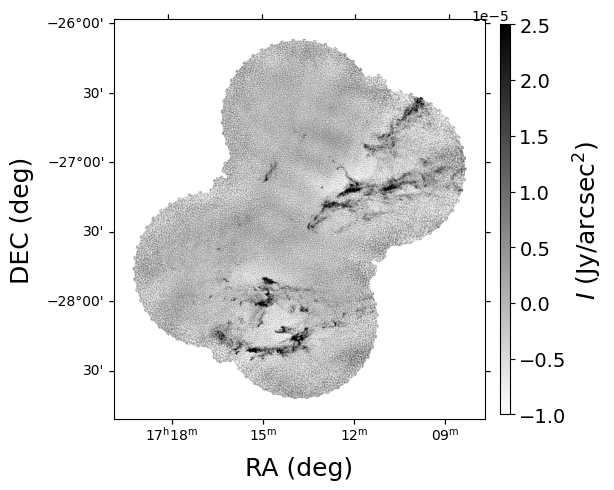

In [87]:
#PLOT RESULT
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=w)
ax.set_xlabel(r"RA (deg)", fontsize=18.)
ax.set_ylabel(r"DEC (deg)", fontsize=18.)
img = ax.imshow(result*mask, vmin=-1.e-5, vmax=2.5e-5, origin="lower", cmap="gray_r")
ax.contour(pb_mean, linestyles="--", levels=[0.05, 0.2], colors=["w","w"])
colorbar_ax = fig.add_axes([0.89, 0.11, 0.02, 0.78])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$I$ (Jy/arcsec$^{2})$", fontsize=18.)
#    plt.savefig(pathout + 'ivis_result_cloud_MeerKAT.png', format='png', bbox_inches='tight', pad_inches=0.02, dpi=400)

In [88]:
# Get tapper for apodization
tapper = fourier.apodize(0.97, shape)
# Reove the mean
field_zm = result - np.mean(result)
# Apply apodization function
field_zm_apod = field_zm * tapper

# Compute the 1D P(k)
ks, sps1d_s = fourier.powspec(field_zm_apod, reso=(target_header["CDELT2"]*u.deg).to(u.arcmin).value)

## Rescaling to match amplitude

For reasons that I don't fully understand, the noise realization obtained from synthetizing random noise with SIGMA from the ms doesn't yield the right scaling. 
Here this scaling factor is being inferred at ks > kmin_fit (in arcmin).

Best-fit noise scaling factor: 0.3497


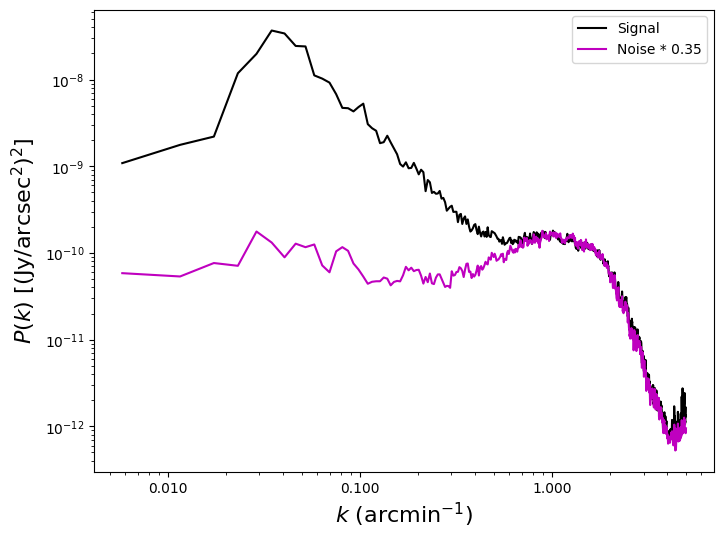

In [131]:
# Assume ks, sps1d_s, and sps1d_n are already defined

# ---- STEP 1: Define a fitting range (e.g., high-k range) ----
kmin_fit = 0.7  # in arcmin^{-1}, adjust as appropriate
fit_mask = ks > kmin_fit

# ---- STEP 2: Fit scaling factor ----
numerator = np.sum(sps1d_s[fit_mask] * sps1d_n[fit_mask])
denominator = np.sum(sps1d_n[fit_mask] ** 2)
scaling_factor = numerator / denominator

print(f"Best-fit noise scaling factor: {scaling_factor:.4f}")

# ---- STEP 3: Plot ----
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(ks, sps1d_s, "-k", label="Signal")
ax.plot(ks, sps1d_n * scaling_factor, "-m", label=f"Noise * {scaling_factor:.2f}")

ax.set_xlabel(r"$k$ (arcmin$^{-1}$)", fontsize=16)
ax.set_ylabel(r"$P(k)$ [(Jy/arcsec$^2$)$^2$]", fontsize=16)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.legend()

Here again you can change the regularization strength to see how it both impact the imaged signal and synthetized noise passed through the IViS.